In [1]:
from qepy import *
from yambopy import *
from qepy import PwIn
import matplotlib.pyplot as plt
import numpy as np
import Routines as R

## Convergence analysis of the self-consistent QE computation

We study the convergence of the self-consistent computation for the determination of the ground state density. The relevant convergence parameteres are the number of k-points and the cutoff on the plane wave expansion

In [2]:
reload(R)
scf_kpoints = [2,3,4,5,6]
scf_ecut = [10,15,20,25,30] #eV
scfDict = R.buildScf(scf_kpoints,scf_ecut)

In [3]:
R.runScf(scfDict,8,True)

skip the computation for : scf/output/k2_ecut10.log
skip the computation for : scf/output/k2_ecut15.log
skip the computation for : scf/output/k2_ecut20.log
skip the computation for : scf/output/k2_ecut25.log
skip the computation for : scf/output/k2_ecut30.log
skip the computation for : scf/output/k3_ecut10.log
skip the computation for : scf/output/k3_ecut15.log
skip the computation for : scf/output/k3_ecut20.log
skip the computation for : scf/output/k3_ecut25.log
skip the computation for : scf/output/k3_ecut30.log
skip the computation for : scf/output/k4_ecut10.log
skip the computation for : scf/output/k4_ecut15.log
skip the computation for : scf/output/k4_ecut20.log
skip the computation for : scf/output/k4_ecut25.log
skip the computation for : scf/output/k4_ecut30.log
skip the computation for : scf/output/k5_ecut10.log
skip the computation for : scf/output/k5_ecut15.log
skip the computation for : scf/output/k5_ecut20.log
skip the computation for : scf/output/k5_ecut25.log
skip the com

In [4]:
# add the energy field to scfDict
for k in scfDict:
    for e in scfDict[k]:
        scfDict[k][e]['energy'] = R.get_totalEnergy(scfDict[k][e]['outputFile'])

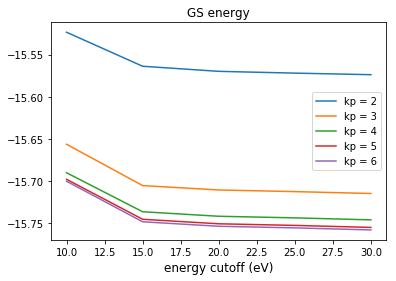

In [5]:
# plot the total energy in function of the ecut for each choice of kpoints
for k in scf_kpoints:
    energy = []
    for e in scf_ecut:
        energy.append(scfDict[k][e]['energy'])
    plt.plot(scf_ecut,energy,label= 'kp = '+str(k))
plt.title('GS energy',size = 12)
plt.xlabel('energy cutoff (eV)',size = 12)
plt.legend()
plt.show()
    

We choose kpoints = 6 and ecut = 30 as convergence parameters of the scf computation

In [6]:
scf_kconv = 6
scf_ecutconv = 30

## QE nscf simulations

We perform a bunch of nscf simulations starting from the results of the scf one with converged parameters.

Nscf simulations use the same value of the ecut parameter found in converged scf computation are performed parametrically in terms of the quantities:

* nscf_kpoints
* nscf_nbnds

In [7]:
nscf_kpoints = [2,4,6,8]
# it is sufficient to give to the nscf_bnds only a single (high) value and
# the parametric run will be done at the subsequent levels
nscf_nbnds = [100]

In [9]:
reload(R)
nscfDict = R.buildNscf(nscf_kpoints,nscf_nbnds,scf_kconv,scf_ecutconv)
#nscfDict

In [10]:
R.runNscf(nscfDict,8,True)

execute : mpirun -np 8 pw.x -inp nscf/input/k2_nb100.nscf > nscf/output/k2_nb100.log
execute : mpirun -np 8 pw.x -inp nscf/input/k4_nb100.nscf > nscf/output/k4_nb100.log
execute : mpirun -np 8 pw.x -inp nscf/input/k6_nb100.nscf > nscf/output/k6_nb100.log
execute : mpirun -np 8 pw.x -inp nscf/input/k8_nb100.nscf > nscf/output/k8_nb100.log


Prepare the system for the yambo computation. Run p2y and yambo (without options) in all the .save folders
generated by the nscf simulations

In [11]:
R.runP2y(nscfDict)

execute : cd nscf/output/k2_nb100.save;p2y;yambo
execute : cd nscf/output/k4_nb100.save;p2y;yambo
execute : cd nscf/output/k6_nb100.save;p2y;yambo
execute : cd nscf/output/k8_nb100.save;p2y;yambo


## Convergence analysis of various approximations for the self energy

Create the high-level yambo folder. For each choice of the nscf parameters create a folder with the name kp_#k_nb#nbnds and the copy the corresponding SAVE directory in the associated folder and perform a nscf QE computation in this folder. 

Structure of the yambo dictionary:

yambo[nscf_kpoints][nscf_nbnds] = {}

This dictionary has a key 'folder' that identifies the folder in which the subsequent yambo
computations are performed and a set of keys like 'hf', 'cosex',.... that contains a further dictionaries with the parameters and results of the different levels of yambo computations 

TODO: the [nscf_nbnds] of the yamboDic can be removed!

In [12]:
reload(R)
yamboDic = R.buildYambo(nscfDict)
#yamboDic

execute : cp -r nscf/output/k8_nb100.save/SAVE yambo/k8_nb100
execute : cp -r nscf/output/k2_nb100.save/SAVE yambo/k2_nb100
execute : cp -r nscf/output/k4_nb100.save/SAVE yambo/k4_nb100
execute : cp -r nscf/output/k6_nb100.save/SAVE yambo/k6_nb100


We discuss different approximations for the self energy $\Sigma = G_0 W$. 
The evaluation of $W$ passes through:
$$
\chi = \chi_0 + \chi_0(v_H+f_{xc})\chi \\
W = v+v\chi v
$$

### HF approximation of $\Sigma$

The HF approximation is realized by posing $W=v$, so that the bare Coulomb potential is used as the screened one. 
In this case the self energy does not depend from the number of empty bands (only the occupied orbitals are relevant).

The relevant parameters for the convergence analysis are the number of k points and the cutoff value of the plane wave expansion of G0 (called G0_Gcomp in what follows). 

In [44]:
G0_Gcomp = [.5,1.0,2.0,3.0,4.0]  #Ha
# compute the HF correction only for the bands in the range
firstbnd = 3
lastbnd = 6

Build the input file and prepare yamboDic

In [45]:
reload(R)
R.buildHF(yamboDic,G0_Gcomp,firstbnd,lastbnd)
#yamboDic

In [46]:
# run the HF simulations
R.runHF(yamboDic,8,True)
#yamboDic

execute : cd yambo/k2_nb100 ; mpirun -np 8 yambo -F hf_gComp0.5.in -J hf_gComp0.5 -C hf_gComp0.5
done!
execute : cd yambo/k2_nb100 ; mpirun -np 8 yambo -F hf_gComp1.0.in -J hf_gComp1.0 -C hf_gComp1.0
done!
execute : cd yambo/k2_nb100 ; mpirun -np 8 yambo -F hf_gComp2.0.in -J hf_gComp2.0 -C hf_gComp2.0
done!
execute : cd yambo/k2_nb100 ; mpirun -np 8 yambo -F hf_gComp3.0.in -J hf_gComp3.0 -C hf_gComp3.0
done!
execute : cd yambo/k2_nb100 ; mpirun -np 8 yambo -F hf_gComp4.0.in -J hf_gComp4.0 -C hf_gComp4.0
done!
execute : cd yambo/k4_nb100 ; mpirun -np 8 yambo -F hf_gComp0.5.in -J hf_gComp0.5 -C hf_gComp0.5
done!
execute : cd yambo/k4_nb100 ; mpirun -np 8 yambo -F hf_gComp1.0.in -J hf_gComp1.0 -C hf_gComp1.0
done!
execute : cd yambo/k4_nb100 ; mpirun -np 8 yambo -F hf_gComp2.0.in -J hf_gComp2.0 -C hf_gComp2.0
done!
execute : cd yambo/k4_nb100 ; mpirun -np 8 yambo -F hf_gComp3.0.in -J hf_gComp3.0 -C hf_gComp3.0
done!
execute : cd yambo/k4_nb100 ; mpirun -np 8 yambo -F hf_gComp4.0.in -J hf_

In [47]:
# reads the results
R.getHFresults(yamboDic)

read file : yambo/k8_nb100/hf_gComp0.5/o-hf_gComp0.5.hf
read file : yambo/k8_nb100/hf_gComp1.0/o-hf_gComp1.0.hf
read file : yambo/k8_nb100/hf_gComp2.0/o-hf_gComp2.0.hf
read file : yambo/k8_nb100/hf_gComp3.0/o-hf_gComp3.0.hf
read file : yambo/k8_nb100/hf_gComp4.0/o-hf_gComp4.0.hf
read file : yambo/k2_nb100/hf_gComp0.5/o-hf_gComp0.5.hf
read file : yambo/k2_nb100/hf_gComp1.0/o-hf_gComp1.0.hf
read file : yambo/k2_nb100/hf_gComp2.0/o-hf_gComp2.0.hf
read file : yambo/k2_nb100/hf_gComp3.0/o-hf_gComp3.0.hf
read file : yambo/k2_nb100/hf_gComp4.0/o-hf_gComp4.0.hf
read file : yambo/k4_nb100/hf_gComp0.5/o-hf_gComp0.5.hf
read file : yambo/k4_nb100/hf_gComp1.0/o-hf_gComp1.0.hf
read file : yambo/k4_nb100/hf_gComp2.0/o-hf_gComp2.0.hf
read file : yambo/k4_nb100/hf_gComp3.0/o-hf_gComp3.0.hf
read file : yambo/k4_nb100/hf_gComp4.0/o-hf_gComp4.0.hf
read file : yambo/k6_nb100/hf_gComp0.5/o-hf_gComp0.5.hf
read file : yambo/k6_nb100/hf_gComp1.0/o-hf_gComp1.0.hf
read file : yambo/k6_nb100/hf_gComp2.0/o-hf_gCom

Analysis of the convergence of $\frac{EHF-E0}{E0}$ in function of the number of nscf_kpoints. Uses the first (and actually the only) value of the parameters nscf_nbnds and nscf_ecut

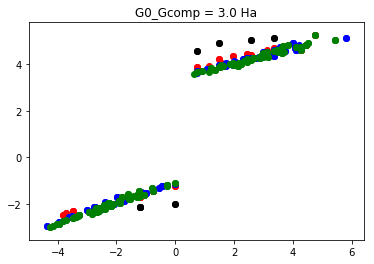

In [48]:
kp = yamboDic.keys()
kp.sort()
nb = nscf_nbnds[0]
gcomp = G0_Gcomp[3]

colors = ['black','red','blue','green']
for ind,k in enumerate(kp):
    y = yamboDic[k][nb]['hf'][gcomp]
    E0 = y['E0']
    EHF = y['EHF']
    for e0,ehf in zip(E0,EHF):
        plt.scatter(e0,ehf-e0,c = colors[ind])
plt.title('G0_Gcomp = '+str(gcomp)+' Ha')
plt.show()

Analysis of the convergence of the gap (both direct and indirect)

HF direct gap (converged) :  7.89563  eV


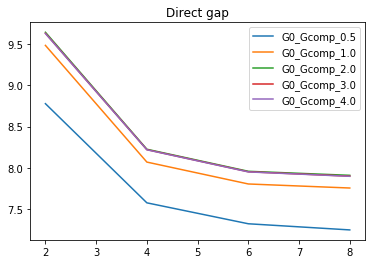

In [49]:
kp = yamboDic.keys()
kp.sort()
nb = nscf_nbnds[0]

dirGap = {}
for gcomp in G0_Gcomp:
    dirGap[gcomp] = []
    for k in kp:
        y = yamboDic[k][nb]['hf'][gcomp]
        ind = 0
        for kVal,bndVal in zip(y['KP'],y['BND']):
            if kVal == 1.0 and bndVal == 4.0:
                break
            else:
                ind +=1
        EHomo = y['EHF'][ind]
        ind = 0
        for kVal,bndVal in zip(y['KP'],y['BND']):
            if kVal == 1.0 and bndVal == 5.0:
                break
            else:
                ind +=1
        ELumo = y['EHF'][ind]
        dirGap[gcomp].append(ELumo-EHomo)

    plt.plot(kp,dirGap[gcomp],label= 'G0_Gcomp_'+str(gcomp))

print 'HF direct gap (converged) : ',dirGap[G0_Gcomp[-1]][-1], ' eV'
plt.title('Direct gap')
plt.legend()
plt.show()

HF indirect gap (converged) :  5.54212  eV


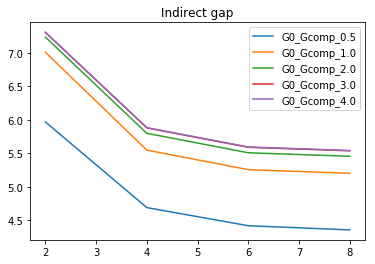

In [50]:
kp = yamboDic.keys()
kp.sort()
nb = nscf_nbnds[0]

# stucture for indirect gap [k] : [khomo,klumo]
# using indGap as difference between homo in Gamma(0,0,0) 
# and lumo in (0.0, -0.5, -0.5) (rlu)
par = {2:[1,3], 4:[1,7], 6:[1,13], 8:[1,21]}

indirGap = {}
for gcomp in G0_Gcomp:
    indirGap[gcomp] = []
    for k in kp:
        y = yamboDic[k][nb]['hf'][gcomp]
        ind = 0
        for kVal,bndVal in zip(y['KP'],y['BND']):
            if kVal == par[k][0] and bndVal == 4.0:
                break
            else:
                ind +=1
        EHomo = y['EHF'][ind]
        ind = 0
        for kVal,bndVal in zip(y['KP'],y['BND']):
            if kVal == par[k][1] and bndVal == 5.0:
                break
            else:
                ind +=1
        ELumo = y['EHF'][ind]
        indirGap[gcomp].append(ELumo-EHomo)

    plt.plot(kp,indirGap[gcomp],label= 'G0_Gcomp_'+str(gcomp))

print 'HF indirect gap (converged) : ',indirGap[G0_Gcomp[-1]][-1], ' eV'
plt.title('Indirect gap')
plt.legend()
plt.show()

This plots conclude the convergence analysis of the HF approximation of the self-energy. On the basis of this analysis we choose the convergence values of the kpoints and G0_gcomp parameters:

In [51]:
hf_kconv = 8
hf_G0_Gcompconv = 3.0 #Ha

### COHSEX approximation (without empties) of $\Sigma$

In the COHSEX one considers only the static contribution of the response $\chi(\omega=0)$ and we also limit our analysis to the Hartree kernel, so that $f_{xc}=0$ (RPA approximations).

In this case (without empties) G0 still depends only from the number of kpoints and from the G0_Gcomp parameter. Moreover we introduce also a non trivial W potential and two more parameters come into the play. These are the cut of in the plane wave expansion of the response function for the construction of W (NGsBlkXs) and the number of empty bands used to write the Lehmann representation of $\chi_0$ (BndsRnXs).

In [61]:
W_Gcomp = [1.0,2.0,3.0,4.0,5.0,6.0] #Ha
W_nb = [10,20,30,40,50]
# compute the COHSEX correction only for the bands in the range
firstk = 1
lastk = 21 # the k index to compute the indirect band gap
firstbnd = 3
lastbnd = 6

In [62]:
reload(R)
R.buildCOHSEX(yamboDic,hf_kconv,hf_G0_Gcompconv,W_Gcomp,W_nb,firstk,lastk,firstbnd,lastbnd)

In [63]:
R.runCOHSEX(yamboDic,hf_kconv,8,True)

execute : cd yambo/k8_nb100 ; mpirun -np 8 yambo -F cs_wGcomp6.0_wNb10.in -J cs_wGcomp6.0_wNb10 -C cs_wGcomp6.0_wNb10
done!
execute : cd yambo/k8_nb100 ; mpirun -np 8 yambo -F cs_wGcomp5.0_wNb50.in -J cs_wGcomp5.0_wNb50 -C cs_wGcomp5.0_wNb50
done!
skip the computation for : yambo/k8_nb100/cs_wGcomp1.0_wNb20/o-cs_wGcomp1.0_wNb20.qp
skip the computation for : yambo/k8_nb100/cs_wGcomp5.0_wNb30/o-cs_wGcomp5.0_wNb30.qp
execute : cd yambo/k8_nb100 ; mpirun -np 8 yambo -F cs_wGcomp6.0_wNb50.in -J cs_wGcomp6.0_wNb50 -C cs_wGcomp6.0_wNb50
done!
skip the computation for : yambo/k8_nb100/cs_wGcomp3.0_wNb10/o-cs_wGcomp3.0_wNb10.qp
skip the computation for : yambo/k8_nb100/cs_wGcomp2.0_wNb30/o-cs_wGcomp2.0_wNb30.qp
skip the computation for : yambo/k8_nb100/cs_wGcomp3.0_wNb20/o-cs_wGcomp3.0_wNb20.qp
skip the computation for : yambo/k8_nb100/cs_wGcomp1.0_wNb10/o-cs_wGcomp1.0_wNb10.qp
execute : cd yambo/k8_nb100 ; mpirun -np 8 yambo -F cs_wGcomp6.0_wNb30.in -J cs_wGcomp6.0_wNb30 -C cs_wGcomp6.0_wNb30


In [64]:
# reads the results
reload(R)
R.getCOHSEXresults(yamboDic,hf_kconv)

read file : yambo/k8_nb100/cs_wGcomp6.0_wNb10/o-cs_wGcomp6.0_wNb10.qp
read file : yambo/k8_nb100/cs_wGcomp5.0_wNb50/o-cs_wGcomp5.0_wNb50.qp
read file : yambo/k8_nb100/cs_wGcomp1.0_wNb20/o-cs_wGcomp1.0_wNb20.qp
read file : yambo/k8_nb100/cs_wGcomp5.0_wNb30/o-cs_wGcomp5.0_wNb30.qp
read file : yambo/k8_nb100/cs_wGcomp6.0_wNb50/o-cs_wGcomp6.0_wNb50.qp
read file : yambo/k8_nb100/cs_wGcomp3.0_wNb10/o-cs_wGcomp3.0_wNb10.qp
read file : yambo/k8_nb100/cs_wGcomp2.0_wNb30/o-cs_wGcomp2.0_wNb30.qp
read file : yambo/k8_nb100/cs_wGcomp3.0_wNb20/o-cs_wGcomp3.0_wNb20.qp
read file : yambo/k8_nb100/cs_wGcomp1.0_wNb10/o-cs_wGcomp1.0_wNb10.qp
read file : yambo/k8_nb100/cs_wGcomp6.0_wNb30/o-cs_wGcomp6.0_wNb30.qp
read file : yambo/k8_nb100/cs_wGcomp4.0_wNb10/o-cs_wGcomp4.0_wNb10.qp
read file : yambo/k8_nb100/cs_wGcomp6.0_wNb40/o-cs_wGcomp6.0_wNb40.qp
read file : yambo/k8_nb100/cs_wGcomp2.0_wNb20/o-cs_wGcomp2.0_wNb20.qp
read file : yambo/k8_nb100/cs_wGcomp3.0_wNb30/o-cs_wGcomp3.0_wNb30.qp
read file : yambo/k8

Analysis of the convergence of the gap (both direct and indirect)

COHSEX direct gap (converged) :  3.707042  eV


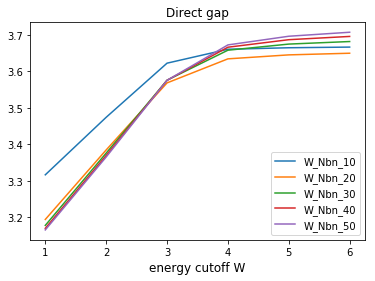

In [65]:
y = yamboDic[hf_kconv][nscf_nbnds[0]]['cs']

dirGap = {}
for wn in W_nb:
    dirGap[wn] = []
    for wg in W_Gcomp:    
        ind = 0
        for kVal,bndVal in zip(y[wg,wn]['KP'],y[wg,wn]['BND']):
            if kVal == 1.0 and bndVal == 4.0:
                break
            else:
                ind +=1
        EHomo = y[wg,wn]['E0'][ind] + y[wg,wn]['EmE0'][ind]
        ind = 0
        for kVal,bndVal in zip(y[wg,wn]['KP'],y[wg,wn]['BND']):
            if kVal == 1.0 and bndVal == 5.0:
                break
            else:
                ind +=1
        ELumo = y[wg,wn]['E0'][ind] + y[wg,wn]['EmE0'][ind]
        dirGap[wn].append(ELumo-EHomo)
    plt.plot(W_Gcomp,dirGap[wn],label= 'W_Nbn_'+str(wn))

print 'COHSEX direct gap (converged) : ',dirGap[W_nb[-1]][-1], ' eV'
plt.xlabel('energy cutoff W',size=12)
plt.title('Direct gap')
plt.legend()
plt.show()

COHSEX (without empties) indirect gap (converged) :  1.813818  eV


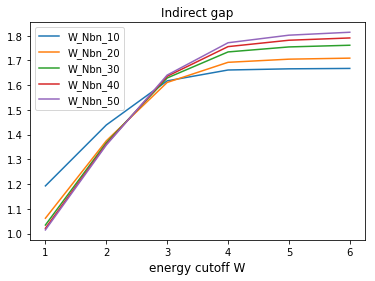

In [66]:
y = yamboDic[hf_kconv][nscf_nbnds[0]]['cs']

# stucture for indirect gap [k] : [khomo,klumo]
# using indGap as difference between homo in Gamma(0,0,0) 
# and lumo in (0.0, -0.5, -0.5) (rlu)
par = {2:[1,3], 4:[1,7], 6:[1,13], 8:[1,21]}

indirGap = {}
for wn in W_nb:
    indirGap[wn] = []
    for wg in W_Gcomp:    
        ind = 0
        for kVal,bndVal in zip(y[wg,wn]['KP'],y[wg,wn]['BND']):
            if kVal == par[hf_kconv][0] and bndVal == 4.0:
                break
            else:
                ind +=1
        EHomo = y[wg,wn]['E0'][ind] + y[wg,wn]['EmE0'][ind]
        ind = 0
        for kVal,bndVal in zip(y[wg,wn]['KP'],y[wg,wn]['BND']):
            if kVal == par[hf_kconv][1] and bndVal == 5.0:
                break
            else:
                ind +=1
        ELumo = y[wg,wn]['E0'][ind] + y[wg,wn]['EmE0'][ind]
        indirGap[wn].append(ELumo-EHomo)

    plt.plot(W_Gcomp,indirGap[wn],label= 'W_Nbn_'+str(wn))

print 'COHSEX (without empties) indirect gap (converged) : ',indirGap[W_nb[-1]][-1], ' eV'
plt.xlabel('energy cutoff W',size=12)
plt.title('Indirect gap')
plt.legend()
plt.show()

This plots conclude the convergence analysis of the COHSEX (without empties) approximation of the self-energy. On the basis of this analysis we choose the convergence values of the W_Gcomp and W_nb parameters:

In [41]:
cs_W_Gcompconv = 6.0 #Ha
cs_W_nbconv = 50

The convergence w.r.t. the number of empty bands of G0 could be analysed within the COHSEX with empties approximation. However it seems that with the actual version of the code the GdndsRnge does not figure out in the yambo input file. So I study the convergence of this quantity directly in the contest of the Plasmom pole approximation.

### Plasmon pole approximation of $\Sigma$

In [ ]:
G0_nb = [10,20]
# compute the pp correction only for the bands in the range
firstk = 1
lastk = 21 # the k index to compute the indirect band gap
firstbnd = 3
lastbnd = 6

In [231]:
fold = 'yambo/k2_nb60'
y = YamboIn('yambo -k hartree -p p -g n -V qp',folder=fold)
y['EXXRLvcs'] = [2.5,'Ha']
y['NGsBlkXp'] = [5,'Ha']
y['BndsRnXp'] = [1,40]
y['GbndRnge'] = [1,10]
krange = y['QPkrange'][0][:2]
kbandrange = krange + [3,6]
y['QPkrange'] = [kbandrange,'']
print y['QPkrange']
fname = 'ppa-inp.in'
y.write(fold+'/'+fname)

[[1, 4, 3, 6], '']


In [232]:
R.runYambo(fold,fname,'ppa-out',8)

delete yambo/k2_nb60/ppa-out
execute : cd yambo/k2_nb60 ; mpirun -np 8 yambo -F ppa-inp.in -J ppa-out -C ppa-out


In [ ]:
###############################################################################

### COHSEX approximation (with empties) of $\Sigma$

In this case we include the contribution of the empty bands in the evaluation of G0. So we perform a new convergence analysis (using the converged values of the previous parameters) in order to find analyse the convergence of the results w.r.t G0_nb

In [156]:
G0_nb = [10,20]
# compute the COHSEXwe correction only for the bands in the range
firstbnd = 3
lastbnd = 6

In [210]:
reload(R)
R.buildCOHSEXWE(yamboDic,2,2.0,2.0,30,G0_nb,firstbnd,lastbnd)
#R.buildCOHSEXWE(yamboDic,hf_kconv,hf_G0_Gcompconv,cs_W_Gcompconv,cs_W_nbconv,G0_nb,firstbnd,lastbnd)

removed # from UseBands field
removed # from UseBands field


In [211]:
R.runCOHSEXWE(yamboDic,2,8,False)
#R.runCOHSEXWE(yamboDic,hf_kconv,8,True)

delete yambo/k2_nb60/cswe_G0nb10
execute : cd yambo/k2_nb60 ; mpirun -np 8 yambo -F cswe_G0nb10.in -J cswe_G0nb10 -C cswe_G0nb10
delete yambo/k2_nb60/cswe_G0nb20
execute : cd yambo/k2_nb60 ; mpirun -np 8 yambo -F cswe_G0nb20.in -J cswe_G0nb20 -C cswe_G0nb20


In [162]:
fold = 'yambo/k2_nb60'
fname = 'yambo.in'
R.runYambo(fold,fname,'prova',8)

delete yambo/k2_nb60/prova
execute : cd yambo/k2_nb60 ; mpirun -np 8 yambo -F yambo.in -J prova -C prova


In [ ]:
# il file yambo.in non viene considerato da yambo in fase di run quindi non ha senso togliere # da UseBands
# in questo file. Devo farlo nel file che lancio ma non ho capito la sintassi....

In [195]:
fold = 'yambo/k2_nb60'
y = YamboIn('yambo -b -k hartee -g n -p c -V qp',folder=fold)

In [187]:
activateUseBand(fold+'/yambo.in')
q = YamboIn(filename = fold+'/'+fname)
q['GbndRnge'] = [1,10]
#print q
fname = 'yambo2.in'
q.write(fold+'/'+fname)

In [191]:
R.runYambo(fold,fname,'prova',8)

delete yambo/k2_nb60/prova
execute : cd yambo/k2_nb60 ; mpirun -np 8 yambo -F yambo2.in -J prova -C prova


### Plasmon pole approximation of $\Sigma$

In [231]:
fold = 'yambo/k2_nb60'
y = YamboIn('yambo -k hartree -p p -g n -V qp',folder=fold)
y['EXXRLvcs'] = [2.5,'Ha']
y['NGsBlkXp'] = [5,'Ha']
y['BndsRnXp'] = [1,40]
y['GbndRnge'] = [1,10]
krange = y['QPkrange'][0][:2]
kbandrange = krange + [3,6]
y['QPkrange'] = [kbandrange,'']
print y['QPkrange']
fname = 'ppa-inp.in'
y.write(fold+'/'+fname)

[[1, 4, 3, 6], '']


In [232]:
R.runYambo(fold,fname,'ppa-out',8)

delete yambo/k2_nb60/ppa-out
execute : cd yambo/k2_nb60 ; mpirun -np 8 yambo -F ppa-inp.in -J ppa-out -C ppa-out


In [ ]:
#############################################################################

In [118]:
#yamboDic[hf_kconv][nscf_nbnds[0]]['cswe']

In [119]:
R.runCOHSEXWE(yamboDic,2,8,True)
#R.runCOHSEXWE(yamboDic,hf_kconv,8,True)

execute : cd yambo/k2_nb60 ; mpirun -np 8 yambo -F cswe_G0nb10.in -J cswe_G0nb10 -C cswe_G0nb10
execute : cd yambo/k2_nb60 ; mpirun -np 8 yambo -F cswe_G0nb20.in -J cswe_G0nb20 -C cswe_G0nb20


In [108]:
# reads the results
reload(R)
R.getCOHSEXWEresults(yamboDic,hf_kconv)

read file : yambo/k8_nb60/cswe_G0nb10/o-cswe_G0nb10.qp
read file : yambo/k8_nb60/cswe_G0nb20/o-cswe_G0nb20.qp


Analysis of the convergence of the gap (both direct and indirect)

In [109]:
y = yamboDic[hf_kconv][nscf_nbnds[0]]['cswe']

dirGap = {}
for wn in W_nb:
    dirGap[wn] = []
    for wg in W_Gcomp:    
        ind = 0
        for kVal,bndVal in zip(y[wg,wn]['KP'],y[wg,wn]['BND']):
            if kVal == 1.0 and bndVal == 4.0:
                break
            else:
                ind +=1
        EHomo = y[wg,wn]['E0'][ind] + y[wg,wn]['EmE0'][ind]
        ind = 0
        for kVal,bndVal in zip(y[wg,wn]['KP'],y[wg,wn]['BND']):
            if kVal == 1.0 and bndVal == 5.0:
                break
            else:
                ind +=1
        ELumo = y[wg,wn]['E0'][ind] + y[wg,wn]['EmE0'][ind]
        dirGap[wn].append(ELumo-EHomo)

    plt.plot(W_Gcomp,dirGap[wn],label= 'W_Nbn_'+str(wn))

print dirGap
plt.xlabel('energy cutoff W',size=12)
plt.title('Direct gap')
plt.legend()
plt.show()

KeyError: (0.5, 10)

COHSEX (without empties) indirect gap (converged) :  1.705066  eV


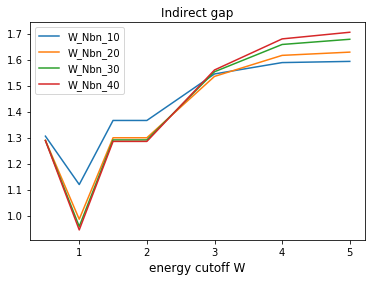

In [44]:
y = yamboDic[hf_kconv][nscf_nbnds[0]]['cs']

# stucture for indirect gap [k] : [khomo,klumo]
# using indGap as difference between homo in Gamma(0,0,0) 
# and lumo in (0.0, -0.5, -0.5) (rlu)
par = {2:[1,3], 4:[1,7], 6:[1,13], 8:[1,21]}

indirGap = {}
for wn in W_nb:
    indirGap[wn] = []
    for wg in W_Gcomp:    
        ind = 0
        for kVal,bndVal in zip(y[wg,wn]['KP'],y[wg,wn]['BND']):
            if kVal == par[hf_kconv][0] and bndVal == 4.0:
                break
            else:
                ind +=1
        EHomo = y[wg,wn]['E0'][ind] + y[wg,wn]['EmE0'][ind]
        ind = 0
        for kVal,bndVal in zip(y[wg,wn]['KP'],y[wg,wn]['BND']):
            if kVal == par[hf_kconv][1] and bndVal == 5.0:
                break
            else:
                ind +=1
        ELumo = y[wg,wn]['E0'][ind] + y[wg,wn]['EmE0'][ind]
        indirGap[wn].append(ELumo-EHomo)

    plt.plot(W_Gcomp,indirGap[wn],label= 'W_Nbn_'+str(wn))

print 'COHSEX (without empties) indirect gap (converged) : ',indirGap[W_nb[-1]][-1], ' eV'
plt.xlabel('energy cutoff W',size=12)
plt.title('Indirect gap')
plt.legend()
plt.show()